<a href="https://colab.research.google.com/github/cormach/bayesian_stats_by_b_lambert/blob/master/Chapter_16_q_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import json
import shutil
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Please use the latest version of CmdStanPy
!pip install --upgrade cmdstanpy

ERROR: fbprophet 0.6 has requirement cmdstanpy==0.4, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.4.0
    Uninstalling cmdstanpy-0.4.0:
      Successfully uninstalled cmdstanpy-0.4.0


In [4]:
# Install pre-built CmdStan binary
# (faster than compiling from source via install_cmdstan() function)
tgz_file = 'colab-cmdstan-2.23.0.tar.gz'
tgz_url = 'https://github.com/stan-dev/cmdstan/releases/download/v2.23.0/colab-cmdstan-2.23.0.tar.gz'
if not os.path.exists(tgz_file):
    urllib.request.urlretrieve(tgz_url, tgz_file)
    shutil.unpack_archive(tgz_file)

In [5]:
# Specify CmdStan location via environment variable
os.environ['CMDSTAN'] = './cmdstan-2.23.0'
# Check CmdStan path
from cmdstanpy import CmdStanModel, cmdstan_path
cmdstan_path()

'./cmdstan-2.23.0'

In [6]:
!pip install arviz

     |████████████████████████████████| 1.5MB 2.6MB/s 
     |████████████████████████████████| 4.1MB 13.2MB/s 
     |████████████████████████████████| 296kB 38.1MB/s 


In [7]:
import arviz as az

Question 16_2 - hangover

In [11]:
url='https://raw.githubusercontent.com/alexandrahotti/Solutions-to-A-Students-Guide-to-Bayesian-Statistics-by-Ben-Lambert/master/All_data/stan_hangover.csv'
df = pd.read_csv(url, error_bad_lines=False, header=0)

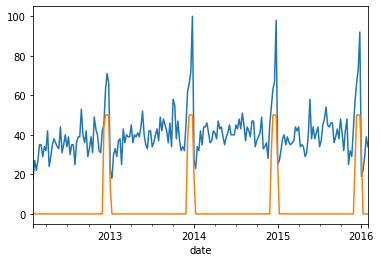

In [16]:
df['date']=pd.to_datetime(df['date'])
fig, ax = plt.subplots()
df.set_index('date').resample('W').sum()['volume'].plot(ax=ax)
df['holiday']=df['holiday']*50
df.set_index('date').resample('W').sum()['holiday'].plot(ax=ax)

In [26]:
stan_text = '''data {
    int T;
    real V[T];
    real h[T];
}
parameters {
    real beta0;
    real beta1;
    real<lower=0> sigma;
}
model {
    for(t in 1:T){
      V[t] ~ normal(beta0 + beta1 *h[t], sigma);
    }

    beta0 ~ normal(0, 50);
    beta1 ~ normal(0, 50);
    sigma ~ normal(0, 10);
}
generated quantities {
  real uplift;
  uplift = beta1 / beta0;
}'''
with open('stan_file.stan', 'w') as f:
  f.write(stan_text)

In [27]:
!cat stan_file.stan

data {
    int T;
    real V[T];
    real h[T];
}
parameters {
    real beta0;
    real beta1;
    real<lower=0> sigma;
}
model {
    for(t in 1:T){
      V[t] ~ normal(beta0 + beta1 *h[t], sigma);
    }

    beta0 ~ normal(0, 50);
    beta1 ~ normal(0, 50);
    sigma ~ normal(0, 10);
}
generated quantities {
  real uplift;
  uplift = beta1 / beta0;
}

In [28]:
stan_model = CmdStanModel(stan_file='stan_file.stan')

INFO:cmdstanpy:compiling stan program, exe file: /content/stan_file
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /content/stan_file


In [36]:
df['holiday']=df['holiday']/50

data = {'V':df.volume.to_numpy(),
        'h':df.holiday.to_numpy(),
        'T':df.shape[0] }

In [37]:
stan_posterior=stan_model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4


In [38]:
stan_posterior.diagnose()

INFO:cmdstanpy:Processing csv files: /tmp/tmp7qyrdlp6/stan_file-202007222022-1-zcob675p.csv, /tmp/tmp7qyrdlp6/stan_file-202007222022-2-sa7_x8m7.csv, /tmp/tmp7qyrdlp6/stan_file-202007222022-3-1i2aw___.csv, /tmp/tmp7qyrdlp6/stan_file-202007222022-4-cwdh6lfx.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /tmp/tmp7qyrdlp6/stan_file-202007222022-1-zcob675p.csv, /tmp/tmp7qyrdlp6/stan_file-202007222022-2-sa7_x8m7.csv, /tmp/tmp7qyrdlp6/stan_file-202007222022-3-1i2aw___.csv, /tmp/tmp7qyrdlp6/stan_file-202007222022-4-cwdh6lfx.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [39]:
stan_posterior.summary().round(decimals=3)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-553.812,0.028,1.260,-556.272,-553.495,-552.476,2086.84,4435.78,1.001
beta0,37.978,0.012,0.642,36.908,37.987,39.007,3026.18,6432.43,1.000
beta1,30.914,0.041,2.347,27.137,30.870,34.716,3320.59,7058.25,1.001
sigma,8.658,0.007,0.427,7.988,8.639,9.392,3291.84,6997.12,1.001
uplift,0.815,0.001,0.067,0.708,0.813,0.923,3047.47,6477.69,1.001


In [40]:
stan_sample = stan_posterior.get_drawset()

In [41]:
az_infdata_obj = az.from_cmdstanpy(
    posterior=stan_posterior,
    posterior_predictive="XSim",
    observed_data=data)

az_infdata_obj

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f887d2eadd8>,
      dtype=object)

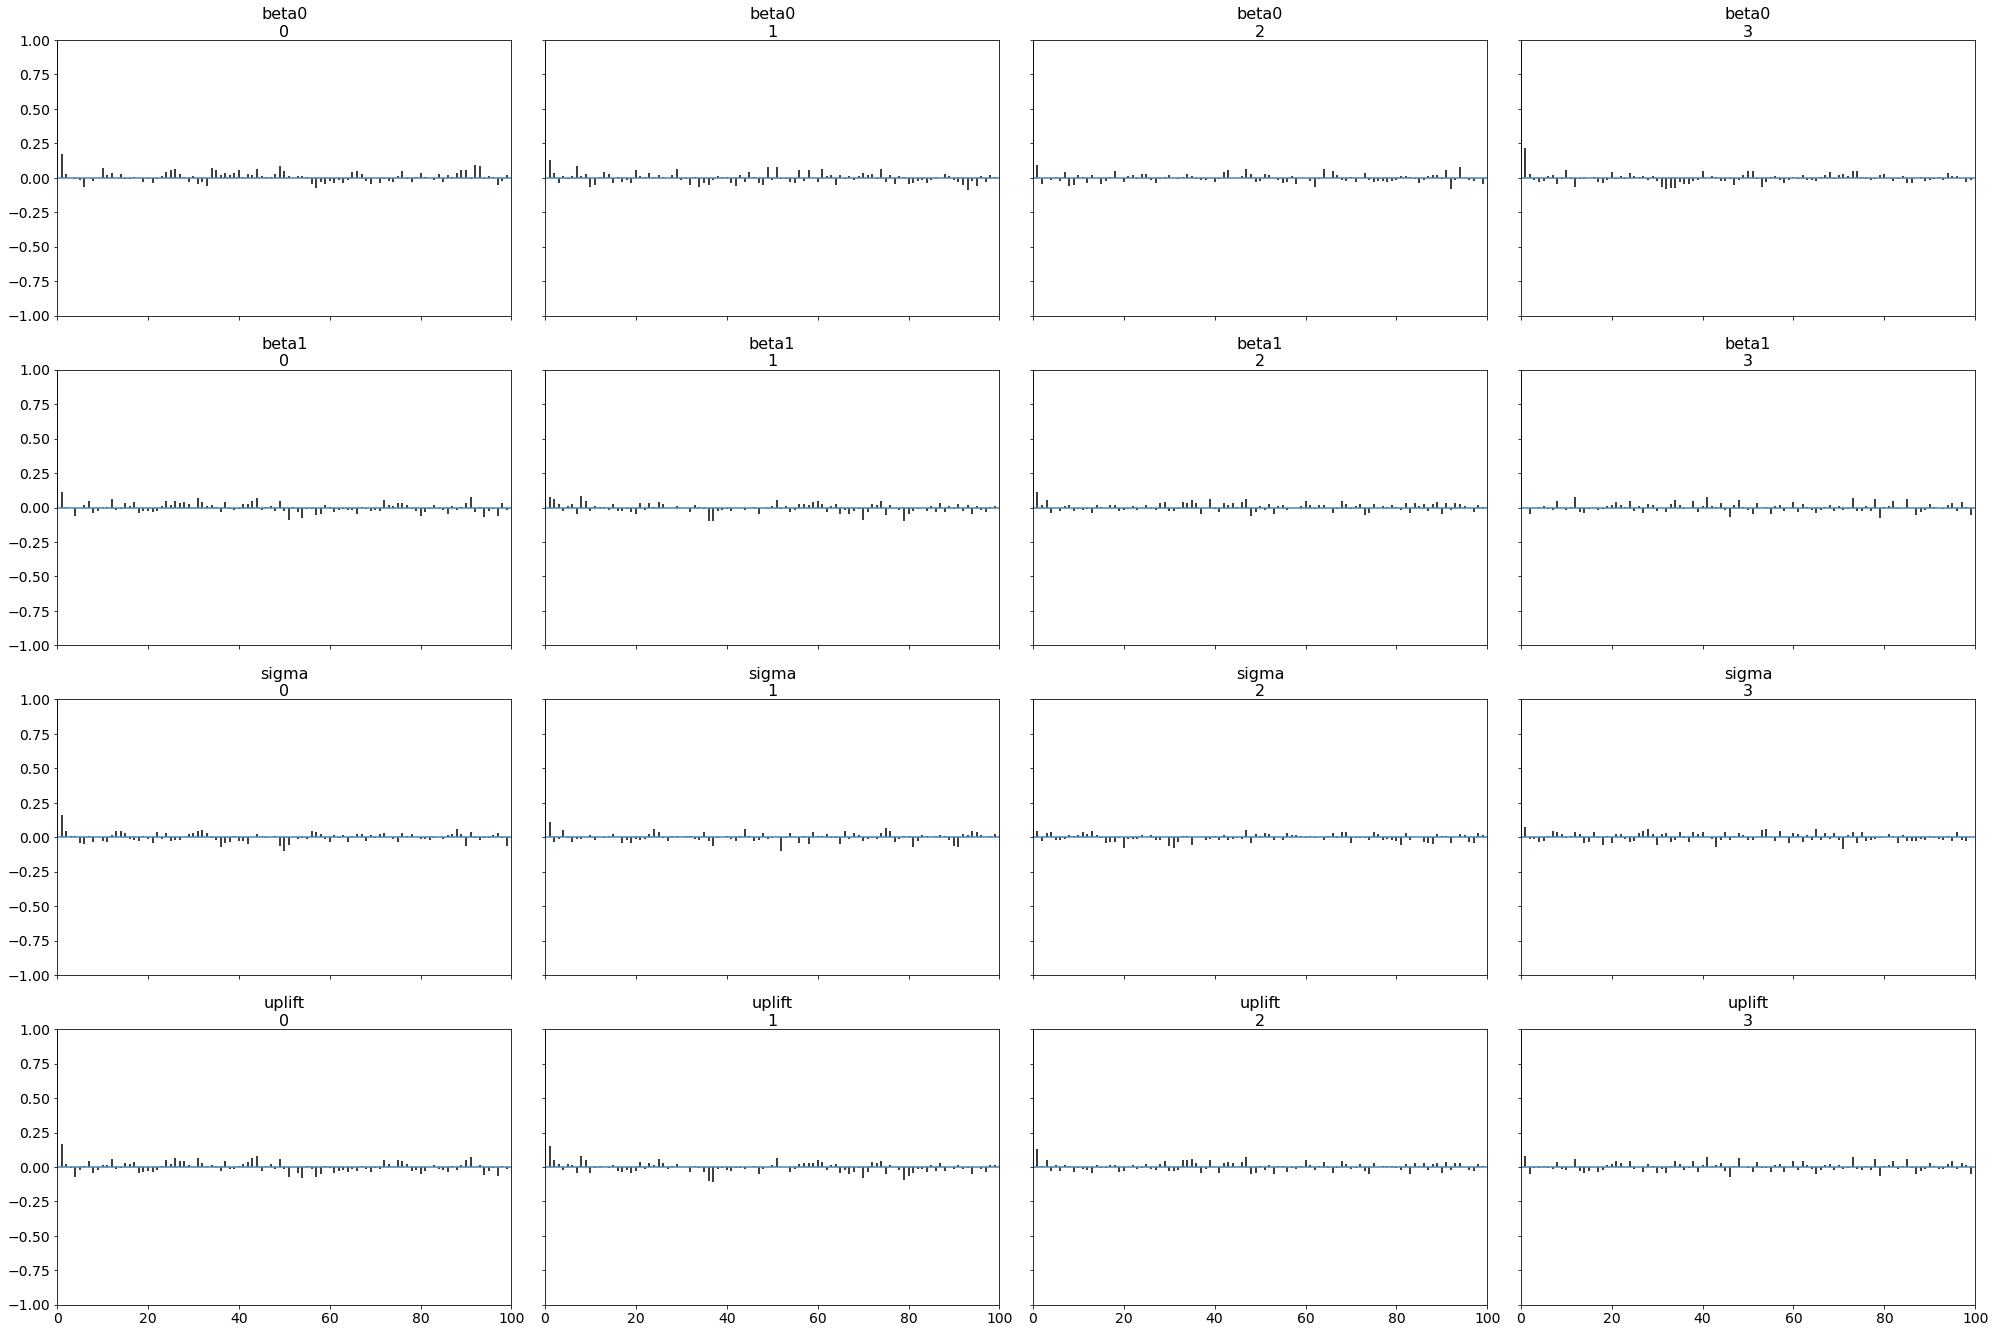

In [42]:
az.plot_autocorr(az_infdata_obj)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f887ac48f28>,
      dtype=object)

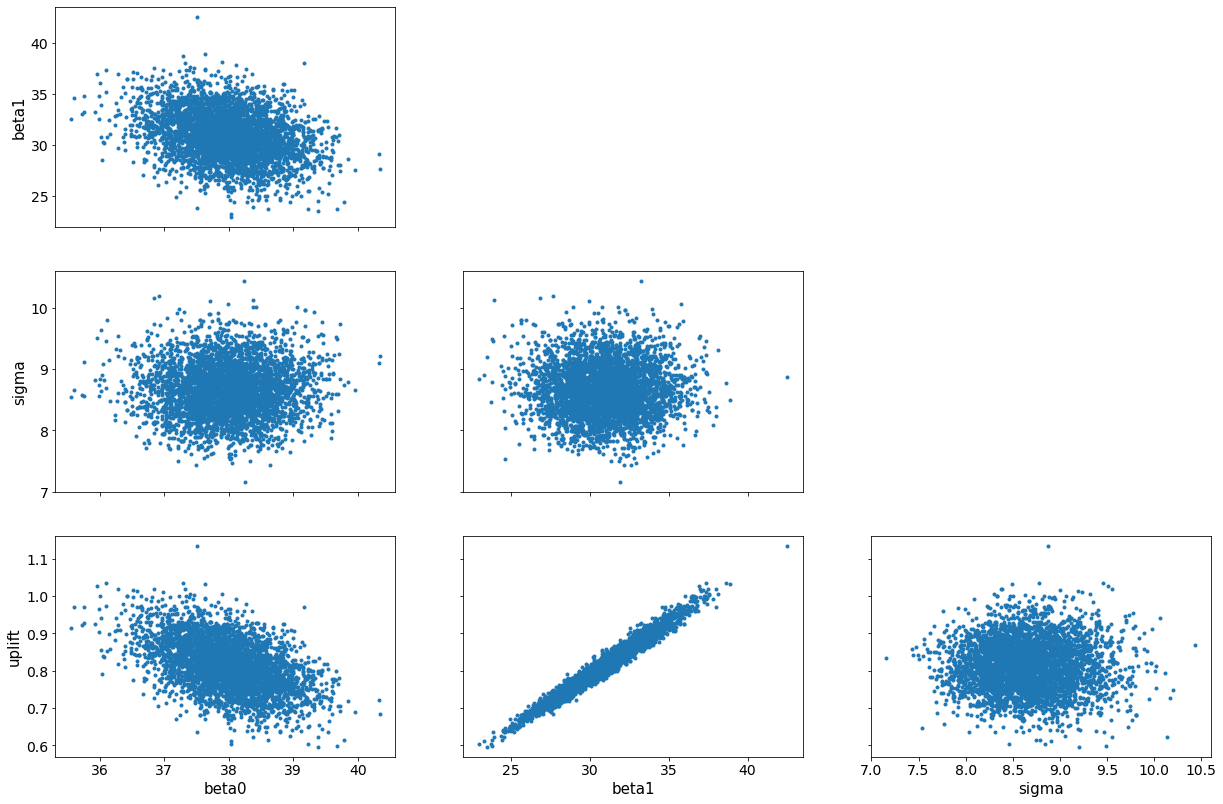

In [43]:
az.plot_pair(az_infdata_obj)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f887a9ee630>,
      dtype=object)

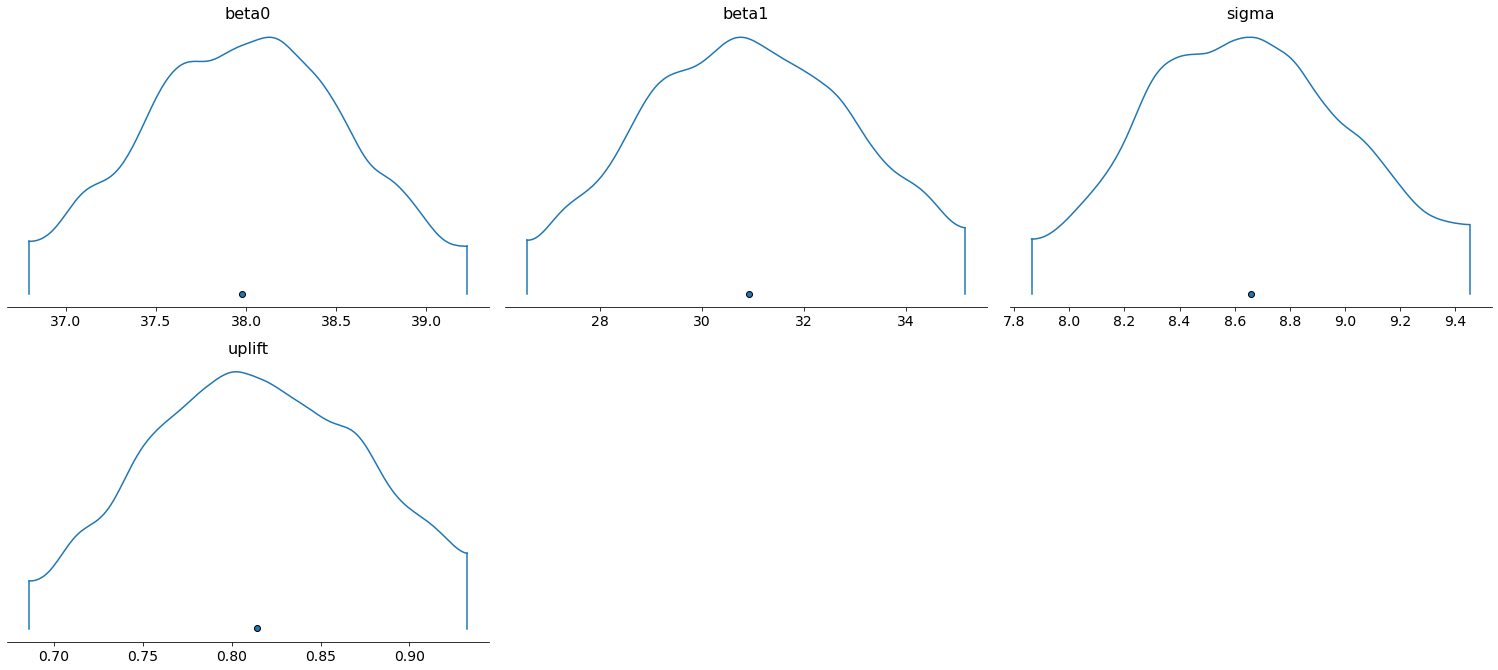

In [44]:
az.plot_density(az_infdata_obj)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f887acb1c88>,
      dtype=object)

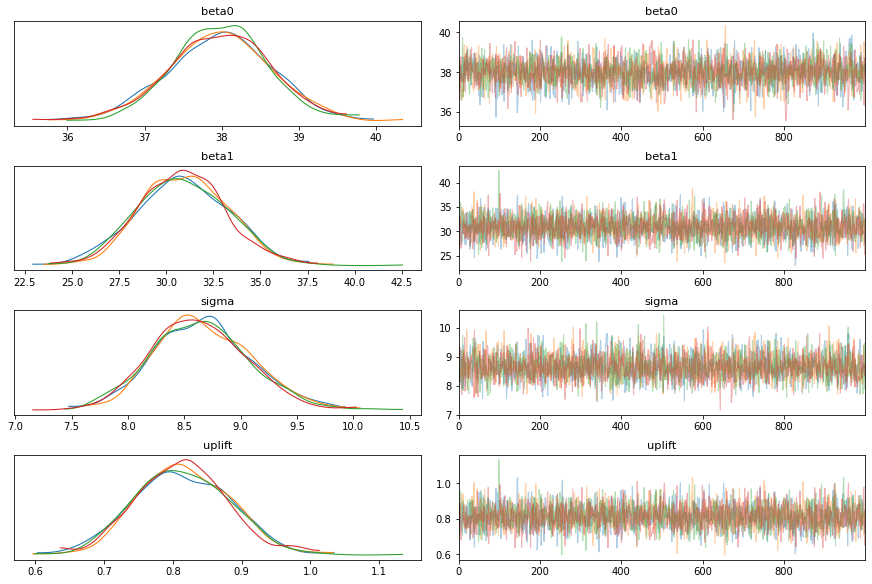

In [45]:
az.plot_trace(az_infdata_obj)